__This notebook__ compares PCA, MDS and Probabilistic Differentiable Graph Embeddings for the task of isometric compression

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "..")
import lib
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import trange
from IPython.display import clear_output
from gensim.downloader import load, info

glove = load('glove-wiki-gigaword-300')
words = sorted(glove.vocab.keys(), key=lambda w: glove.vocab[w].index)[:10000]
X = glove[words].astype('float32')
X = X / np.square(X).sum(-1, keepdims=True) ** 0.5

In [2]:
from lib.task.compression import make_graph_from_vectors
emb = make_graph_from_vectors(
        X, knn_edges=64, random_edges=32, squared=False,
        max_length=10, n_jobs=-1, soft=True, k_nearest=0, directed=False
)

loss_history, reg_history = [], []
batch_size = 256
opt = None
total_edges = emb.num_edges
stage = 0

def update_learning_rate():
    t = len(loss_history)
    global opt, stage, emb, batch_size
    
    if stage == 0:
        opt = torch.optim.SparseAdam(emb.parameters(), lr=0.1)
        stage += 1
        
    if stage == 1 and t >= 3000:
        emb = emb.pruned(threshold=0.5)
        opt = torch.optim.SparseAdam(emb.parameters(), lr=0.05)
        stage += 1
    
    if stage == 2 and t >= 10000:
        emb = emb.pruned(threshold=0.5)
        opt = torch.optim.SparseAdam(emb.parameters(), lr=0.01)
        stage += 1


In [3]:
# pre-compute reference distances
distances = np.concatenate([
    np.square(X[None, :, :] - X[batch_start: batch_start + batch_size, None, :]).sum(-1) ** 0.5
    for batch_start in trange(0, len(X), batch_size)
])
# ^-- replacing cosine with squared l2 distance because
# |x - y|_2^2 = |x|_2^2 + |y|_2^2- 2 * <x, y> and |x| = |y| = 1

100%|██████████| 40/40 [03:11<00:00,  3.17s/it]


### Training loop

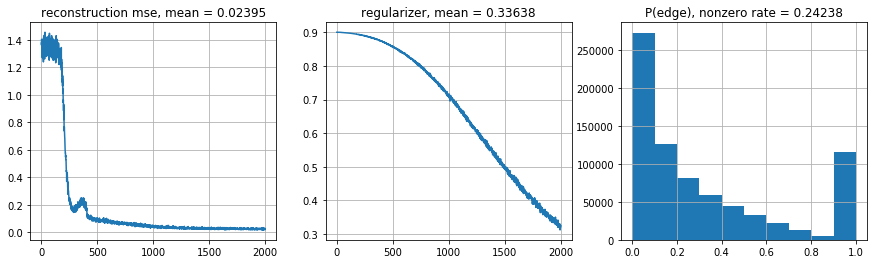

................................

In [ ]:
for batch_i in range(len(loss_history), 100000):
    print(end='.')
    update_learning_rate()
    ii = torch.randint(0, len(X), [batch_size])
    jj = torch.randint(0, len(X), [batch_size])
    
    pred = emb(ii, jj)
    distances_ref = torch.as_tensor(distances[ii, jj], dtype=torch.float32)
    
    reconstruction_mse = F.mse_loss(pred['target_distances'], distances_ref)
    regularizer = emb.compute_l0_prior_penalty(batch_size=4096)
    
    lambd = min(1, len(loss_history) / 10000.) * (emb.num_edges / total_edges) * 10.0
    loss = reconstruction_mse - pred['logp_target_paths'].mean() + lambd * regularizer
            
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_history.append(reconstruction_mse.item())
    reg_history.append(regularizer.item())
    
    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[15, 4])
        plt.subplot(1, 3, 1);
        plt.title('reconstruction mse, mean = %0.5f' % np.mean(loss_history[-100:])); plt.grid()
        plt.plot(loss_history)
        
        plt.subplot(1, 3, 2);
        plt.title('regularizer, mean = %0.5f' % np.mean(reg_history[-100:])); plt.grid()
        plt.plot(reg_history)

        plt.subplot(1, 3, 3);
        probs = torch.sigmoid(emb.edge_adjacency_logits).data.numpy().ravel()
        plt.title('P(edge), nonzero rate = %.5f' % (np.sum(probs > 0.5) / total_edges))
        plt.grid();
        plt.hist(probs)
        plt.show()

# batch/s rate will increase at 5k and 10k steps

In [4]:
print("params per vertex = %.4f" % (emb.report_model_size()['num_parameters'] / len(X)))

params per vertex = 3.9642


In [5]:
distances_ours = emb.compute_pairwise_distances()

### Baselines:

We train two other common compression methods as our baselines:
* __PCA:__ Principial Component Analysis learns to project data onto lower dimensional space in a way that captures as much variance as possible. This method is considered a __weak__ baseline as it does not minimize the target metric.
* __MDS:__ Multidimensional Scaling solves the same optimization problem as our method, but in a vector space. We expect this method to outperform PCA given the same number of components.

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4).fit(X)
X_pca = pca.inverse_transform(pca.transform(X))
distances_pca = np.concatenate([
    np.square(X_pca[None, :, :] - X_pca[batch_start: batch_start + batch_size, None, :]).sum(-1) ** 0.5
    for batch_start in range(0, len(X_pca), batch_size)
])

In [7]:
from sklearn.manifold import MDS
mds = MDS(n_components=4, random_state=42, n_jobs=-1, dissimilarity='euclidean')
X_mds = mds.fit_transform(X)
distances_mds = np.square(X_mds[None, :, :] - X_mds[:, None, :]).sum(-1) ** 0.5

In [8]:
print("PCA:\t %.5f" % np.mean(np.square(distances - distances_pca)))
print("MDS:\t %.5f" % np.mean(np.square(distances - distances_mds)))
print("PRODIGE: %.5f" % np.mean(np.square(distances - distances_ours)))

PCA:	 0.84912
MDS:	 0.13142
PRODIGE: 0.05289
